In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

In [112]:


class H_theta(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(H_theta, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 200),
            nn.ReLU(),
            nn.Linear(200, 200),
            nn.ReLU(),
            nn.Linear(200, 200),
            nn.ReLU(),
            nn.Linear(200, output_dim)
        )

    def forward(self, x):
        return self.fc(x)


def generate_line_distribution(n, length=1.0):
    x = torch.linspace(-length/2, length/2, n).view(-1, 1)
    y = 2*x
    #noise = np.random.normal(0, 0.1, y.shape)
    #y += noise
    return torch.cat((x, y), dim=1)


def generate_different_line_distribution(n, length=1.0):
    x = torch.linspace(-length/2, length/2, n).view(-1, 1)
    y = 2*x + 2
    #noise = np.random.normal(0, 0.1, y.shape)
    #y += noise
    return torch.cat((x, y), dim=1)

def generate_parabola_points(n, a=1.0):
    x = torch.linspace(-a, a, n).view(-1, 1) - 0.5
    y = (x) ** 2 + 0.5
    noise = np.random.normal(0, 0.1, y.shape)
    #y += noise
    return torch.cat((x, y), dim=1)


def generate_reverse_parabola_points(n, a=1.0):
    x = torch.linspace(-a, a, n).view(-1, 1) - 0.5
    y = -x ** 2 -0.5
    noise = np.random.normal(0, 0.1, y.shape)
    #y += noise
    return torch.cat((x, y), dim=1)


def generate_Z(n, z_dim, lambda_val):
    Z = torch.zeros(n, z_dim + 1, z_dim)
    for i in range(n):
        z = torch.randn(z_dim) * lambda_val ** 2
        I = torch.eye(z_dim)
        Z[i] = torch.cat((z.unsqueeze(0), I), dim=0)
    return Z

def generate_Z_tensor(n, b=2):
    rows = b + 2
    cols = 2
    Z_tensor = torch.zeros((n, rows, cols))
    for i in range(n):

        z = torch.normal(0, 1, size=(b,))

        Z = torch.zeros((rows, cols))

        for j in range(b):
            Z[j, j] = z[j]
        Z[b, 0] = 1
        Z[b+1, 1] = 1

        Z_tensor[i] = Z

    return Z_tensor

def find_nns(Y, G):
    Y = Y.unsqueeze(0)
    result = torch.empty(40)
    for i in range(40):
        diffs = (((G[i, :, 0] - Y[0, :, 0]) ** 2 + (G[i, :, 1] - Y[0, :, 1]) ** 2)).sum()
        result[i] = diffs

    return torch.argmin(result).item()

# def find_nns(H, Y):
#     sum_of_min_distances = torch.zeros(40)
#     Y = Y.unsqueeze(0)
#     for i in range(40):
#         H_i = H[i]
#         sum_min_distances_i = 0
#         for h in H_i:
#             distances = torch.norm(Y - h, dim=1)**2
#             min_distance = torch.min(distances)
#             sum_min_distances_i += min_distance
#         sum_of_min_distances[i] = sum_min_distances_i
#     return torch.argmin(sum_of_min_distances).item()

def f_loss(Y, G):

    #indices_curve1 = torch.randint(0, 1000, (100,))
    #indices_curve2 = torch.randint(0, 1000, (100,))
    #Y_sampled_curve1 = Y[0, indices_curve1, :]
    #Y_sampled_curve2 = Y[1, indices_curve2, :]
    #Y = torch.stack((Y_sampled_curve1, Y_sampled_curve2), dim=0) #(2, 100, 2)
    #G_sampled_curve1 = G[0, indices_curve1, :]
    #G_sampled_curve2 = G[1, indices_curve2, :]

    #G = torch.stack((G_sampled_curve1, G_sampled_curve2), dim=0)


    diffs1 = (((G[0, :, 0] - Y[0, :, 0]) ** 2) + ((G[0, :, 1] - Y[0, :, 1]) ** 2)) #Curve 1
    diffs2 = (((G[1, :, 0] - Y[1, :, 0]) ** 2) + ((G[1, :, 1] - Y[1, :, 1]) ** 2)) #Curve 2
    result = torch.min(diffs1, diffs2).mean()
    # result = diffs1.sum()
    # result = torch.min(diffs1)
    #result = (diffs1.mean() + diffs2.mean())/2
    return result

def generate_Zx(Z, points):

    if Z.shape[0] == 1:

        Z_expanded = Z.expand(points.shape[0], -1, -1)
        result = torch.bmm(Z_expanded, points.unsqueeze(2)).squeeze(2)
        result = result.unsqueeze(0)
    else:
        points_expanded = points.unsqueeze(0).expand(Z.shape[0], -1, -1)
        result = torch.bmm(points_expanded, Z.transpose(1, 2))

    return result

torch.Size([2, 5000, 2])


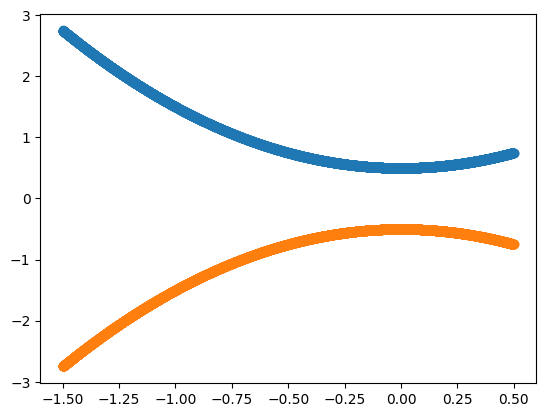

100%|██████████| 2000/2000 [00:33<00:00, 60.45it/s]


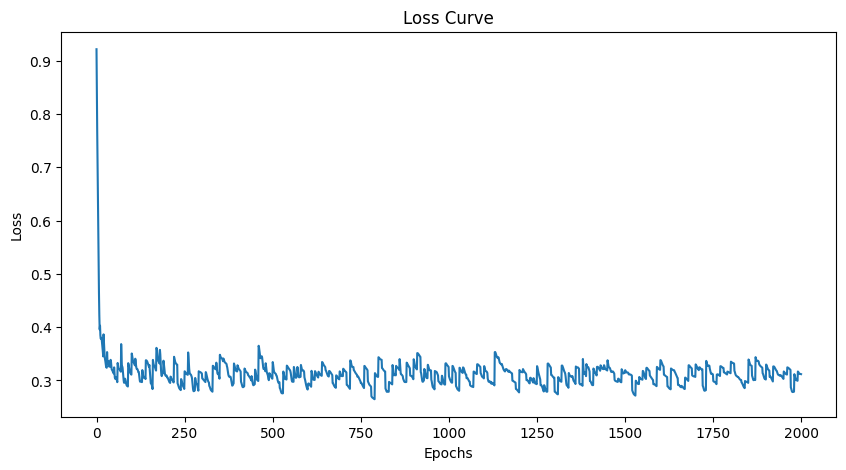

In [113]:
epochs = 2000
zdim = 2
lambda_val = 1
noise_coef = 0.1
staleness = 10
lr = 0.001

n_points = 5000

Y = generate_parabola_points(n_points)
Y2 = generate_reverse_parabola_points(n_points)
Y3 = generate_line_distribution(n_points)
Y4 = generate_different_line_distribution(n_points)
Ys = torch.stack([Y, Y2])
print(Ys.shape)
for i in Ys:
    plt.scatter(i[:, 0], i[:, 1])
plt.show()

model = H_theta(input_dim=zdim+2, output_dim=2)
optimizer = optim.Adam(model.parameters(), lr=lr)
num_samples = 1000
losses = []
Y_o = Ys




for e in tqdm(range(epochs)):

    with torch.no_grad():
        if e % staleness == 0:
            #Sample points from circle
            t = torch.randn(num_samples, 1) * 2 * np.pi
            points = torch.cat([torch.cos(t), torch.sin(t)], dim=1) #(num_samples, 2)


            # Sample from Ys
            indices_curve1 = torch.randint(0, 5000, (num_samples,))
            indices_curve2 = torch.randint(0, 5000, (num_samples,))
            Y_sampled_curve1 = Y_o[0, indices_curve1, :]
            Y_sampled_curve2 = Y_o[1, indices_curve2, :]
            Ys = Y_o[0, indices_curve1, :]
            Ys = Y_o[1, indices_curve1, :]

            Ys = torch.stack((Y_sampled_curve1, Y_sampled_curve2), dim=0) #(2, num_samples, 2)

            #Generating n different Zs
            Zs = generate_Z_tensor(40, b = zdim) #(40, 4, 2)

            #Caculate the n values of Z(x)s and get the output from H
            transformed_points = generate_Zx(Zs, points) #(40, num_samples, 4)

            generated = model(transformed_points) #(40, num_samples, 2)

            #Find Z(x) which produced the closest curve to any of the Ys
            imle_nns = torch.tensor([find_nns(d, generated) for d in Ys], dtype=torch.long) #(2)
            imle_nn_z = Zs[imle_nns] #(2, 4, 2)

    optimizer.zero_grad()
    imle_transformed_points = generate_Zx(imle_nn_z, points) #(2, num_samples, 4)
    outs = model(imle_transformed_points) #(2, num_samples, 2)
    loss = f_loss(Ys, outs) #(1)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()


plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.show()


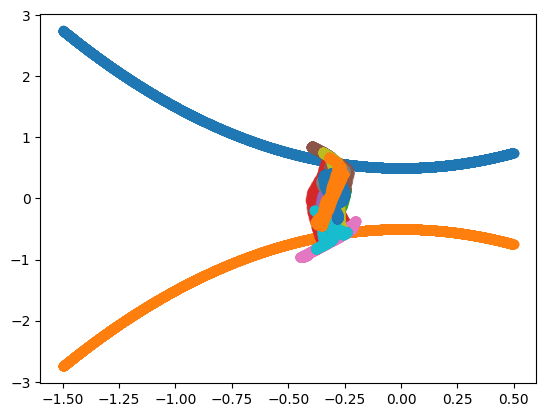

In [115]:
#Select n ts uniformly using linspace between 0 and 2pi
t = torch.rand(1000, 1) * 2 * np.pi
points = torch.cat([torch.cos(t), torch.sin(t)], dim=1)
Ys = Y_o
for i in Ys:
    plt.scatter(i[:, 0], i[:, 1])
for i in range(10):

    Z = generate_Z_tensor(1, zdim)
    transformed_points = generate_Zx(Z, points)
    H = model(transformed_points)
    #plot points in H
    H = H.detach().numpy()


    plt.scatter(H[:, :, 0], H[:, :, 1], alpha = 0.5)
plt.show()

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Assuming Y2, Y, generate_Z_tensor, generate_Zx, and model are defined elsewhere in the code
t = torch.rand(1000, 1) * 2 * np.pi
points = torch.cat([torch.cos(t), torch.sin(t)], dim=1)
Ys = Y_o

# Generate and save each frame

frames = []
for i in range(50):
    plt.figure()


    for j in Ys:
        plt.scatter(j[:, 0], j[:, 1])

    Z = generate_Z_tensor(1, zdim)
    transformed_points = generate_Zx(Z, points)
    H = model(transformed_points)

    # Plot points in H
    H = H.detach().numpy()
    plt.scatter(H[:, :, 0], H[:, :, 1], alpha=0.5)

    # Save the frame
    plt.savefig(f'frames/frame_{i}.png')
    plt.close()

    # Open the saved frame and append to the frames list
    frames.append(Image.open(f'frames/frame_{i}.png'))

# Combine frames into a GIF
frames[0].save('animated_curve.gif', format='GIF', append_images=frames[1:], save_all=True, duration=200, loop=0)
